# Lightning Prediction

Importing necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import pickle
import warnings
warnings.filterwarnings("ignore")


2022-02-06 06:08:33.724687: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-06 06:08:33.724721: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Load the Dataset

In [2]:
df = pd.read_csv('garo_train.csv')
df.head()

,Unnamed: 0,QV2M,RH2M,PRECTOTCORR,T2M,T2MDEW,T2MWET,PS,WS10M,WD10M,WS50M,WD50M,timestamp,lightning
0,0,7.26,83.75,0.0,11.85,9.22,10.54,100.34,1.39,157.90,1.80,145.97,2002-01-01 00:00:00,0
1,1,7.26,84.94,0.0,11.69,9.26,10.48,100.33,1.25,160.66,1.54,147.04,2002-01-01 01:00:00,0
2,2,7.32,86.56,0.0,11.46,9.32,10.39,100.31,0.99,150.20,1.20,130.52,2002-01-01 02:00:00,0
3,3,7.32,88.69,0.0,11.12,9.34,10.23,100.30,0.99,139.79,1.27,119.40,2002-01-01 03:00:00,0
4,4,7.32,91.81,0.0,10.61,9.35,9.98,100.34,1.32,142.72,1.71,127.97,2002-01-01 04:00:00,0


In [3]:
df = df.drop('timestamp', 1)


In [4]:
df = df.iloc[: , 1:]

In [5]:
df.head()

,QV2M,RH2M,PRECTOTCORR,T2M,T2MDEW,T2MWET,PS,WS10M,WD10M,WS50M,WD50M,lightning
0,7.26,83.75,0.0,11.85,9.22,10.54,100.34,1.39,157.90,1.80,145.97,0
1,7.26,84.94,0.0,11.69,9.26,10.48,100.33,1.25,160.66,1.54,147.04,0
2,7.32,86.56,0.0,11.46,9.32,10.39,100.31,0.99,150.20,1.20,130.52,0
3,7.32,88.69,0.0,11.12,9.34,10.23,100.30,0.99,139.79,1.27,119.40,0
4,7.32,91.81,0.0,10.61,9.35,9.98,100.34,1.32,142.72,1.71,127.97,0


In [6]:
df.describe()

,QV2M,RH2M,PRECTOTCORR,T2M,T2MDEW,T2MWET,PS,WS10M,WD10M,WS50M,WD50M,lightning
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,14.952540,77.275826,0.248977,23.903945,19.255986,21.579974,99.344704,2.143208,146.844572,3.328655,146.876040,0.030023
std,5.075079,16.350700,0.740163,5.854475,5.861242,5.501281,0.598432,0.900442,86.799518,1.492232,84.912727,0.170660
min,5.000000,23.690000,0.000000,8.500000,3.700000,6.720000,97.500000,0.010000,0.000000,0.020000,0.000000,0.000000
25%,10.130000,66.060000,0.000000,19.650000,14.120000,17.080000,98.880000,1.550000,74.045000,2.220000,76.390000,0.000000
50%,15.440000,80.000000,0.000000,25.160000,20.705000,23.010000,99.380000,2.080000,134.595000,3.240000,135.185000,0.000000
75%,19.710000,91.560000,0.160000,28.230000,24.650000,26.350000,99.830000,2.630000,211.907500,4.320000,210.902500,0.000000
max,24.050000,100.000000,31.190000,35.590000,27.870000,30.010000,100.700000,5.980000,359.760000,8.800000,359.800000,1.000000


In [7]:
df.isnull().sum().max()

0

No Null Values

In [8]:
# The classes are heavily skewed we need to solve this issue later.
print('No Lightning', round(df['lightning'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Lightning', round(df['lightning'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Lightning 97.0 % of the dataset
Lightning 3.0 % of the dataset


In [9]:
#scaling the columns 
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['sc_RH2M'] = rob_scaler.fit_transform(df['RH2M'].values.reshape(-1,1))
df['sc_QV2M'] = rob_scaler.fit_transform(df['QV2M'].values.reshape(-1,1))
df['sc_PRECTOTCORR'] = rob_scaler.fit_transform(df['PRECTOTCORR'].values.reshape(-1,1))
df['sc_T2M'] = rob_scaler.fit_transform(df['T2M'].values.reshape(-1,1))
df['sc_T2MDEW'] = rob_scaler.fit_transform(df['T2MDEW'].values.reshape(-1,1))
df['sc_T2MWET'] = rob_scaler.fit_transform(df['T2MWET'].values.reshape(-1,1))
df['sc_PS'] = rob_scaler.fit_transform(df['PS'].values.reshape(-1,1))
df['sc_WS10M'] = rob_scaler.fit_transform(df['WS10M'].values.reshape(-1,1))
df['sc_WD10M'] = rob_scaler.fit_transform(df['WD10M'].values.reshape(-1,1))
df['sc_WS50M'] = rob_scaler.fit_transform(df['WS50M'].values.reshape(-1,1))
df['sc_WD50M'] = rob_scaler.fit_transform(df['WD50M'].values.reshape(-1,1))
df.drop(['RH2M','QV2M','PRECTOTCORR', 'T2M','T2MDEW','T2MWET','PS','WS10M','WD10M','WS50M','WD50M'], axis=1, inplace=True)

In [10]:
df.head()

,lightning,sc_RH2M,sc_QV2M,sc_PRECTOTCORR,sc_T2M,sc_T2MDEW,sc_T2MWET,sc_PS,sc_WS10M,sc_WD10M,sc_WS50M,sc_WD50M
0,0,0.147059,-0.853862,0.0,-1.551282,-1.090693,-1.345200,1.010526,-0.638889,0.169045,-0.685714,0.080178
1,0,0.193725,-0.853862,0.0,-1.569930,-1.086895,-1.351672,1.000000,-0.768519,0.189065,-0.809524,0.088133
2,0,0.257255,-0.847599,0.0,-1.596737,-1.081197,-1.361381,0.978947,-1.009259,0.113192,-0.971429,-0.034681
3,0,0.340784,-0.847599,0.0,-1.636364,-1.079297,-1.378641,0.968421,-1.009259,0.037682,-0.938095,-0.117350
4,0,0.463137,-0.847599,0.0,-1.695804,-1.078348,-1.405609,1.010526,-0.703704,0.058936,-0.728571,-0.053638


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Lightning', round(df['lightning'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Lightning', round(df['lightning'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('lightning', axis=1)
y = df['lightning']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Lightning 97.0 % of the dataset
Lightning 3.0 % of the dataset
Train: [1721 1722 1723 ... 8757 8758 8759] Test: [   0    1    2 ... 2201 2345 2346]
Train: [   0    1    2 ... 8757 8758 8759] Test: [1721 1722 1723 ... 3525 3526 3527]
Train: [   0    1    2 ... 8757 8758 8759] Test: [3209 3210 3211 ... 5293 5294 5295]
Train: [   0    1    2 ... 8757 8758 8759] Test: [4104 4267 4268 ... 7055 7056 7057]
Train: [   0    1    2 ... 7055 7056 7057] Test: [5660 5661 5677 ... 8757 8758 8759]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.97003425 0.02996575]
[0.96974886 0.03025114]


In [12]:
df['lightning'].value_counts()[1]

263

In [13]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
lightning_df = df.loc[df['lightning'] == 1]
no_lightning_df = df.loc[df['lightning'] == 0][:263]

normal_distributed_df = pd.concat([lightning_df, no_lightning_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,lightning,sc_RH2M,sc_QV2M,sc_PRECTOTCORR,sc_T2M,sc_T2MDEW,sc_T2MWET,sc_PS,sc_WS10M,sc_WD10M,sc_WS50M,sc_WD50M
7946,0,0.784314,-0.407098,0.000,-1.076923,-0.426876,-0.748652,0.568421,0.240741,-0.349878,0.561905,-0.374352
5566,0,0.683922,0.401879,3.375,-0.058275,0.337607,0.156419,-0.557895,0.379630,-0.412694,0.809524,-0.421485
5888,1,-0.654510,0.318372,0.375,0.735431,0.277778,0.489752,0.073684,-0.981481,0.635525,-0.914286,0.603252
3562,1,-0.784314,0.108559,0.125,0.609557,0.100190,0.330097,-0.126316,0.203704,-0.434890,-0.200000,-0.404684
1477,1,-1.659216,-0.720251,0.000,0.241259,-0.876068,-0.394822,0.042105,0.212963,1.096273,-0.142857,1.052133


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: lightning, dtype: float64


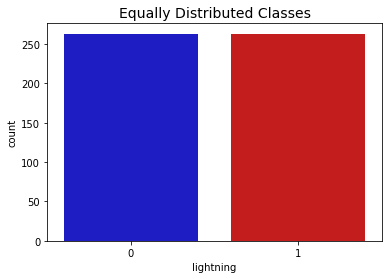

In [14]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['lightning'].value_counts()/len(new_df))
colors = ["#0101DF", "#DF0101"]



sns.countplot('lightning', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Findingg Correlation

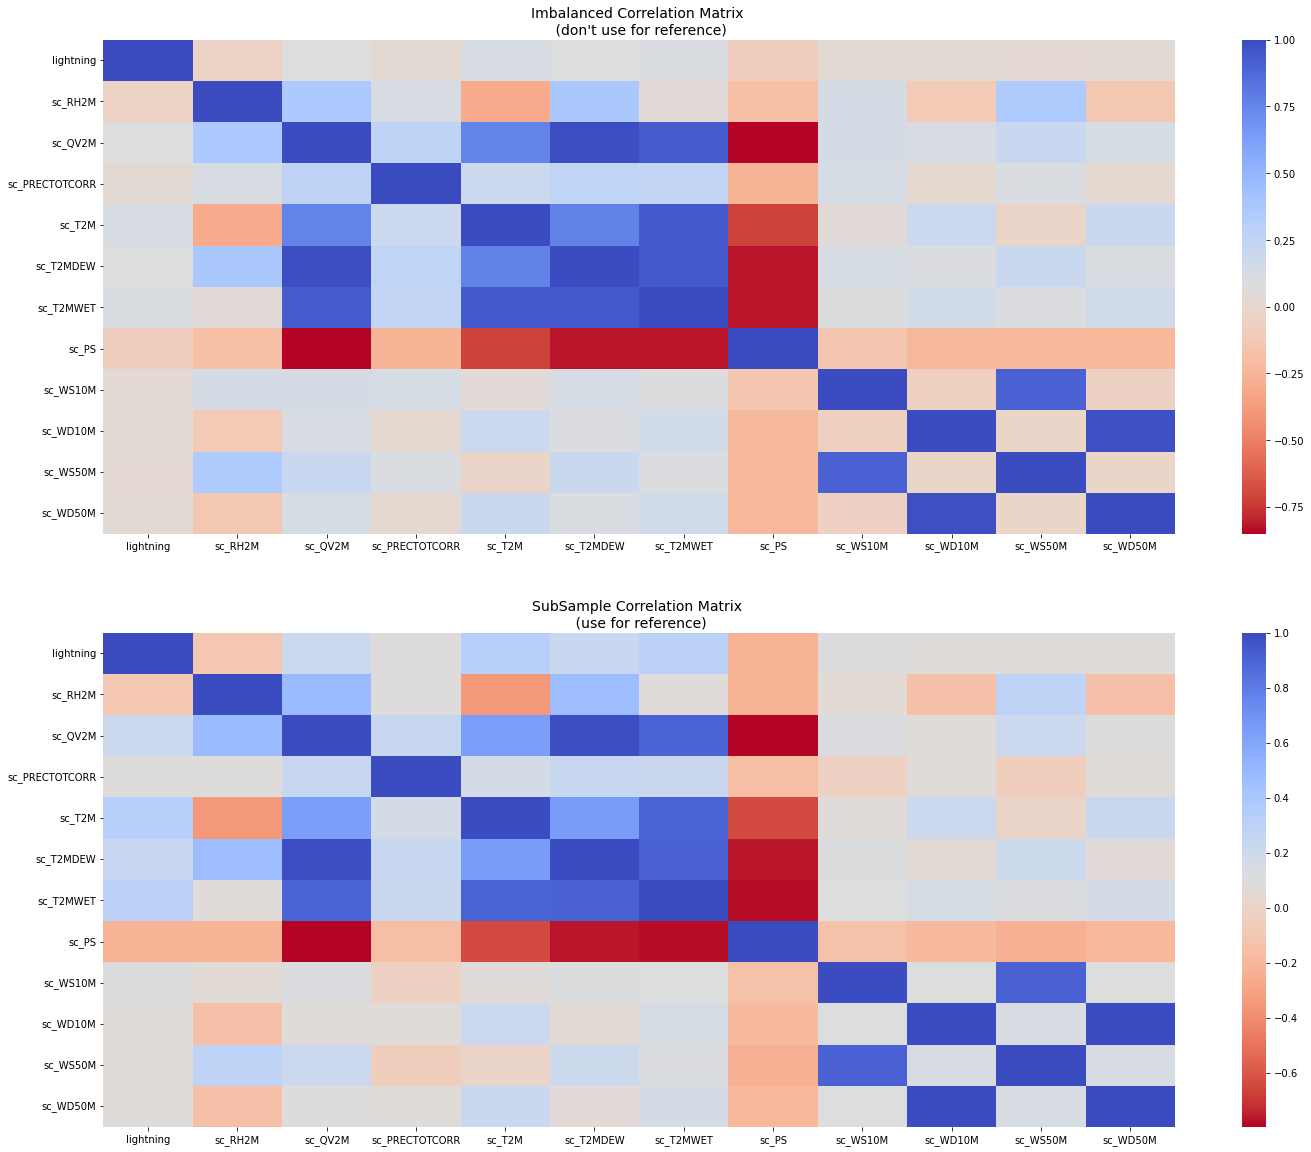

In [15]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [16]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('lightning', axis=1)
y = new_df['lightning']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.6 s
PCA took 0.013 s
Truncated SVD took 0.0031 s


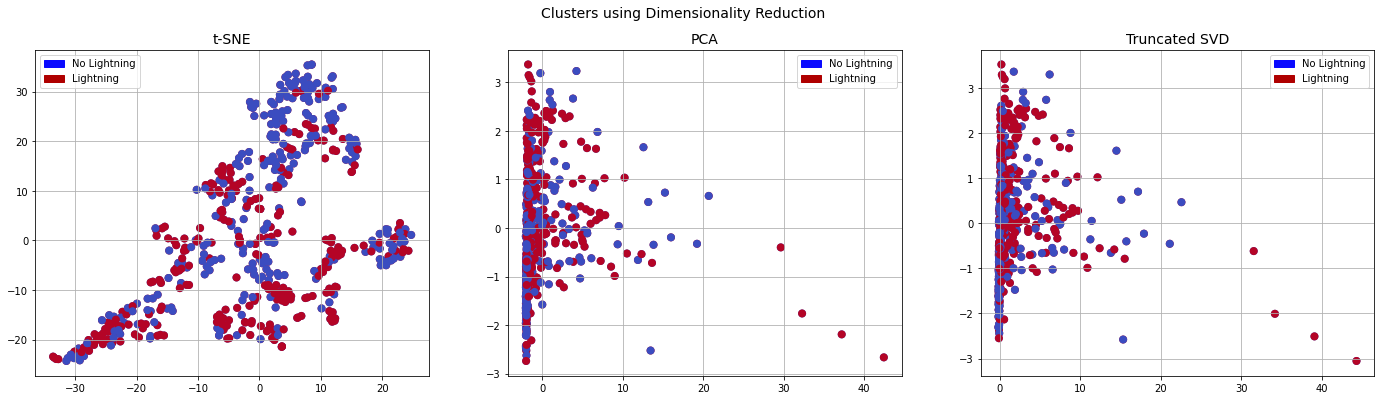

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Lightning')
red_patch = mpatches.Patch(color='#AF0000', label='Lightning')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Lightning', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Lightning', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Lightning', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Lightning', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Lightning', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Lightning', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()


In [18]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('lightning', axis=1)
y = new_df['lightning']

In [19]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [21]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [22]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 61.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 64.0 % accuracy score
Classifiers:  SVC Has a training score of 60.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 62.0 % accuracy score


In [23]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_


In [24]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  62.62%
Knears Neighbors Cross Validation Score 65.24%
Support Vector Classifier Cross Validation Score 61.67%
DecisionTree Classifier Cross Validation Score 58.81%


In [25]:
# We will undersample during cross validating
undersample_X = df.drop('lightning', axis=1)
undersample_y = df['lightning']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [1726 1744 1754 ... 8757 8758 8759] Test: [   0    1    2 ... 1751 1752 1753]
Train: [   0    1    2 ... 8757 8758 8759] Test: [1726 1744 1754 ... 3512 3513 3514]
Train: [   0    1    2 ... 8757 8758 8759] Test: [3170 3193 3274 ... 5253 5254 5255]
Train: [   0    1    2 ... 8757 8758 8759] Test: [5256 5257 5258 ... 7005 7006 7007]
Train: [   0    1    2 ... 7005 7006 7007] Test: [7008 7009 7010 ... 8757 8758 8759]
NearMiss Label Distribution: Counter({0: 263, 1: 263})


In [26]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [27]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.6568614068614069
KNears Neighbors:  0.6422331422331422
Support Vector Classifier:  0.636932386932387
Decision Tree Classifier:  0.5978023478023478


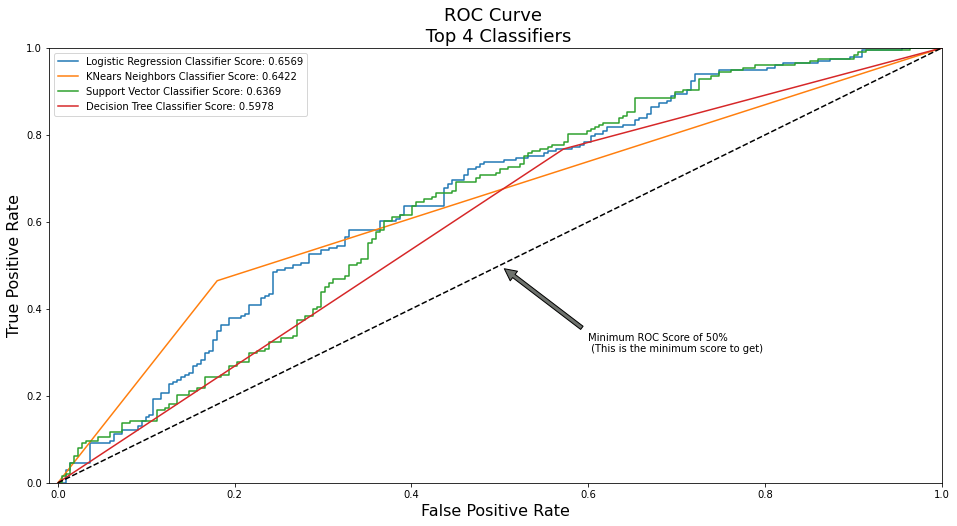

In [28]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

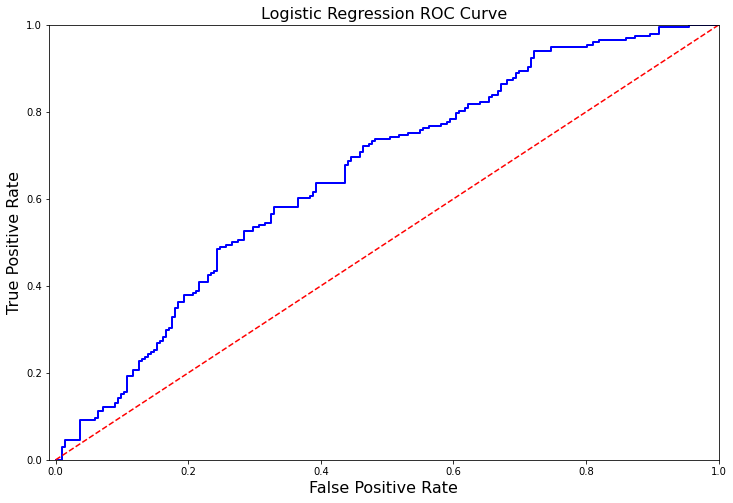

In [29]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [30]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)


In [31]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.80
Precision Score: 0.55
F1 Score: 0.65
Accuracy Score: 0.60
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.44
Precision Score: 0.03
Recall Score: 0.40
F1 Score: 0.05
---------------------------------------------------------------------------------------------------------------------------------------


In [32]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [33]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.14


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.14')

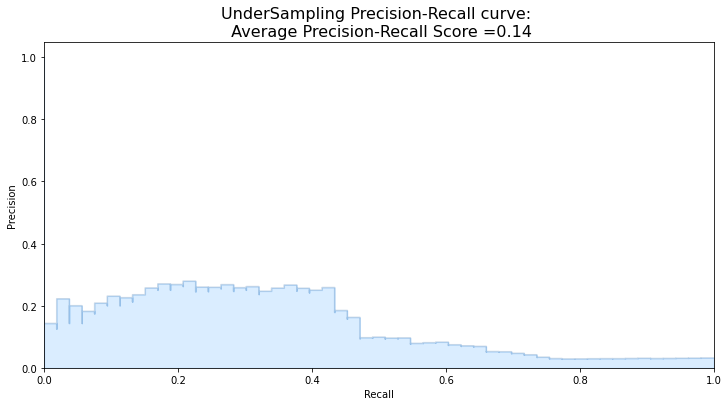

In [34]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)


In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 7008 | Length of y (train): 7008
Length of X (test): 1752 | Length of y (test): 1752
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.5177921619059547
precision: 0.22430621909938714
recall: 0.5095238095238095
f1: 0.08089976450041901
---------------------------------------------------------------------------------------------------------------------------------------


In [36]:
labels = ['No Lightning', 'Lightning']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

No Lightning       0.97      0.69      0.81      1699
   Lightning       0.04      0.42      0.07        53

    accuracy                           0.68      1752
   macro avg       0.51      0.55      0.44      1752
weighted avg       0.95      0.68      0.79      1752



In [37]:
y_score = best_est.decision_function(original_Xtest)

In [38]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.05


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.05')

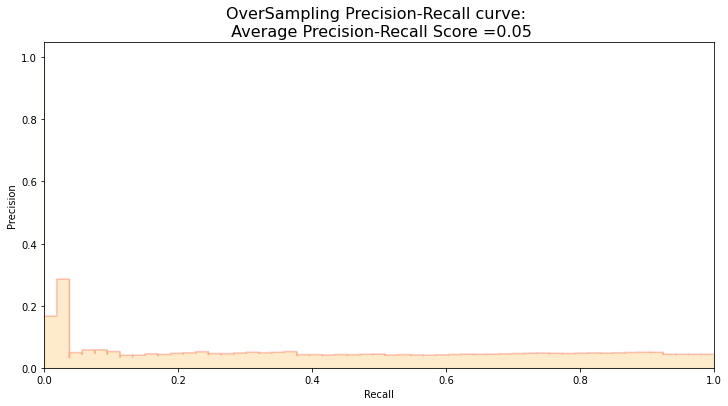

In [39]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [40]:
# # SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)
# # Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# # This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [41]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :0.3475785255432129 sec


[Text(0, 0.5, ''), Text(0, 1.5, '')]

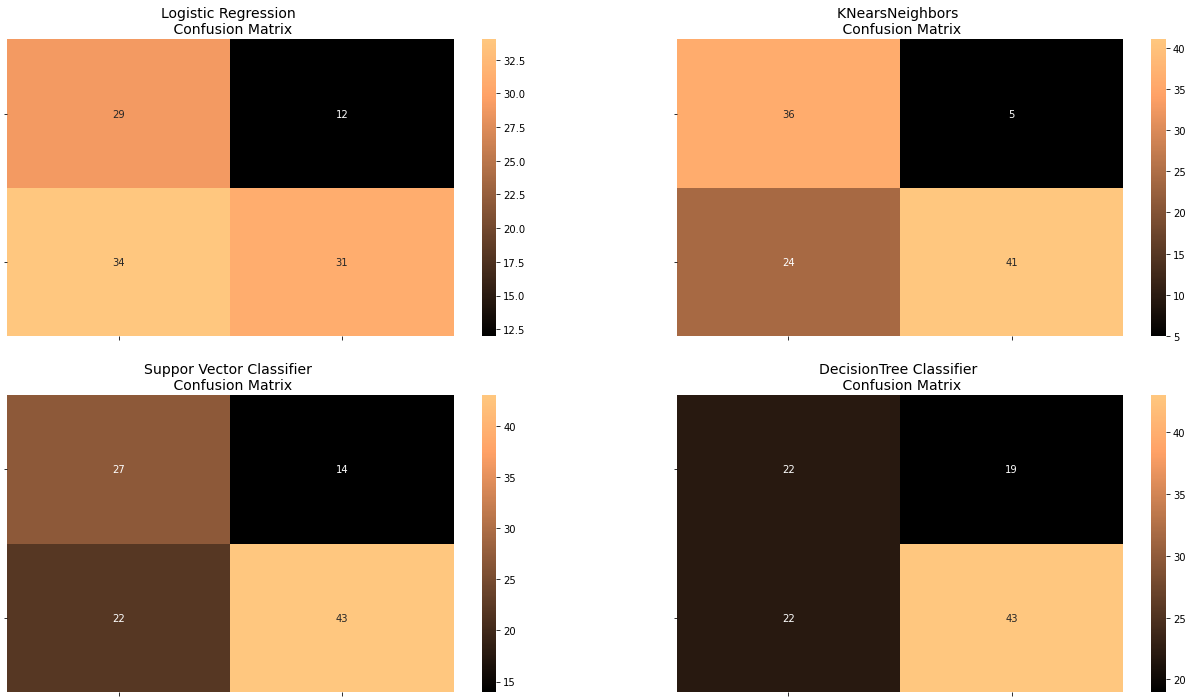

In [42]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


In [43]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.46      0.71      0.56        41
           1       0.72      0.48      0.57        65

    accuracy                           0.57       106
   macro avg       0.59      0.59      0.57       106
weighted avg       0.62      0.57      0.57       106

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.60      0.88      0.71        41
           1       0.89      0.63      0.74        65

    accuracy                           0.73       106
   macro avg       0.75      0.75      0.73       106
weighted avg       0.78      0.73      0.73       106

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60        41
           1       0.75      0.66      0.70        65

    accuracy                           0.66       106
   macro avg       0.65      0.66      0.65       106
weighted

In [44]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df


,Technique,Score
0,Random UnderSampling,0.566038
1,Oversampling (SMOTE),0.684361


In [45]:
# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Activation
# from keras.layers.core import Dense
# from tensorflow.keras.optimizers import Adam
# from keras.metrics import categorical_crossentropy

# n_inputs = X_train.shape[1]

# undersample_model = Sequential([
#     Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(2, activation='softmax')
# ])

In [48]:
#undersample_model.summary()

In [49]:
#undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
#undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=100, shuffle=True, verbose=2)

In [51]:
#undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [52]:
#undersample_lightning_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)


In [53]:
# n_inputs = Xsm_train.shape[1]

# oversample_model = Sequential([
#     Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(2, activation='softmax')
# ])

In [54]:
#oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [55]:
#oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=200, shuffle=True, verbose=2)

In [56]:
#oversample_lightning_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [57]:
#oversample_model.save("name.h5")

## Testing

Testing on Idukki district of Kerala, India

In [58]:
test=pd.read_csv('test.csv')
X_test = test.drop('lightning', axis=1)
y_test = test['lightning']
X_test.shape

(8760, 12)

In [59]:
X_test.head()

,Unnamed: 0,sc_RH2M,sc_QV2M,sc_PRECTOTCORR,sc_T2M,sc_T2MDEW,sc_T2MWET,sc_PS,sc_WS10M,sc_WD10M,sc_WS50M,sc_WD50M
0,0,0.073894,-0.750853,-0.071429,-0.693237,-0.745161,-1.144681,0.851852,0.428571,-1.019542,0.541494,-0.980535
1,1,0.071458,-0.832765,-0.071429,-0.763285,-0.835484,-1.268085,0.629630,0.468254,-1.035702,0.578838,-0.994553
2,2,0.058465,-0.897611,-0.071429,-0.801932,-0.906452,-1.348936,0.629630,0.484127,-1.045492,0.591286,-1.003492
3,3,0.068616,-0.938567,-0.071429,-0.835749,-0.932258,-1.395745,0.703704,0.444444,-1.047545,0.541494,-1.005879
4,4,0.084044,-0.938567,-0.071429,-0.859903,-0.948387,-1.425532,0.888889,0.468254,-1.035702,0.562241,-0.997041


In [60]:
del X_test[X_test.columns[0]]

In [61]:
y_test.shape

(8760,)

In [62]:
import pickle
with open('logreg_pkl', 'wb') as files:
    pickle.dump(log_reg, files)


In [63]:
with open('logreg_pkl' , 'rb') as f:
    lr = pickle.load(f)

In [64]:
a=lr.predict(X_test) 
df_res = pd.DataFrame(a, columns = ['logistic_regression'])
final=pd.merge(df_res,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final.lightning, final.logistic_regression)

logistic_regression,0,1
lightning,,
0,5529,3124
1,32,75


In [65]:
with open('knn_pkl', 'wb') as files:
    pickle.dump(knears_neighbors, files)
with open('knn_pkl' , 'rb') as f:
    knn = pickle.load(f)


In [66]:
b=knn.predict(X_test) 
df_res2 = pd.DataFrame(b, columns = ['K_NN'])
final2=pd.merge(df_res2,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final2.lightning, final2.K_NN)

K_NN,0,1
lightning,,
0,6808,1845
1,75,32


In [67]:
with open('svc_pkl', 'wb') as files:
    pickle.dump(svc, files)
with open('svc_pkl' , 'rb') as f:
    sv_c = pickle.load(f)

In [68]:
c=sv_c.predict(X_test) 
df_res3 = pd.DataFrame(c, columns = ['SVM'])
final3=pd.merge(df_res3,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final3.lightning, final3.SVM)

SVM,0,1
lightning,,
0,5220,3433
1,16,91


In [69]:
with open('tree_pkl', 'wb') as files:
    pickle.dump(tree_clf, files)
with open('tree_pkl' , 'rb') as f:
    tree = pickle.load(f)

In [70]:
d=tree.predict(X_test) 
df_res4= pd.DataFrame(d, columns = ['Decision_Tree'])
final4=pd.merge(df_res4,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final4.lightning, final4.Decision_Tree)

Decision_Tree,0,1
lightning,,
0,5175,3478
1,68,39


The best accuracy is shown by SVC that is 47%

## Testing on San Diego

In [71]:
test=pd.read_csv('test_sandiego.csv')
X_test = test.drop('lightning', axis=1)
y_test = test['lightning']
X_test.shape

(8760, 12)

In [72]:
X_test.head()

,Unnamed: 0,sc_RH2M,sc_QV2M,sc_PRECTOTCORR,sc_T2M,sc_T2MDEW,sc_T2MWET,sc_PS,sc_WS10M,sc_WD10M,sc_WS50M,sc_WD50M
0,0,0.868000,0.179104,0.01,-0.675204,0.191769,-0.348310,0.595745,-0.309434,-1.796339,-0.191228,-1.692055
1,1,0.868000,0.089552,0.01,-0.752037,0.108613,-0.447582,0.595745,-0.196226,-1.725877,-0.047368,-1.631254
2,2,0.868000,-0.026119,0.01,-0.806752,0.003394,-0.540009,0.510638,-0.105660,-1.612414,0.085965,-1.521756
3,3,0.868000,-0.138060,0.01,-0.837020,-0.106916,-0.617030,0.446809,-0.067925,-1.486461,0.156140,-1.402782
4,4,0.821232,-0.231343,0.03,-0.852154,-0.198557,-0.676936,0.446809,-0.037736,-1.395690,0.208772,-1.317210


In [73]:
del X_test[X_test.columns[0]]

In [74]:
a=lr.predict(X_test) 
df_res = pd.DataFrame(a, columns = ['logistic_regression'])
final=pd.merge(df_res,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final.lightning, final.logistic_regression)

logistic_regression,0,1
lightning,,
0,6682,1997
1,53,28


In [75]:
b=knn.predict(X_test) 
df_res2 = pd.DataFrame(b, columns = ['K_NN'])
final2=pd.merge(df_res2,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final2.lightning, final2.K_NN)

K_NN,0,1
lightning,,
0,7146,1533
1,66,15


In [76]:
c=sv_c.predict(X_test) 
df_res3 = pd.DataFrame(c, columns = ['SVM'])
final3=pd.merge(df_res3,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final3.lightning, final3.SVM)

SVM,0,1
lightning,,
0,5721,2958
1,27,54


In [77]:
d=tree.predict(X_test) 
df_res4= pd.DataFrame(d, columns = ['Decision_Tree'])
final4=pd.merge(df_res4,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final4.lightning, final4.Decision_Tree)

Decision_Tree,0,1
lightning,,
0,4840,3839
1,37,44


## Testing on Florida

In [78]:
test=pd.read_csv('test_florida.csv')
X_test = test.drop('lightning', axis=1)
y_test = test['lightning']
X_test.shape

(8760, 12)

In [79]:
del X_test[X_test.columns[0]]

In [80]:
a=lr.predict(X_test) 
df_res = pd.DataFrame(a, columns = ['logistic_regression'])
final=pd.merge(df_res,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final.lightning, final.logistic_regression)

logistic_regression,0,1
lightning,,
0,6577,2027
1,112,44


In [81]:
b=knn.predict(X_test) 
df_res2 = pd.DataFrame(b, columns = ['K_NN'])
final2=pd.merge(df_res2,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final2.lightning, final2.K_NN)

K_NN,0,1
lightning,,
0,7036,1568
1,123,33


In [82]:
c=sv_c.predict(X_test) 
df_res3 = pd.DataFrame(c, columns = ['SVM'])
final3=pd.merge(df_res3,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final3.lightning, final3.SVM)

SVM,0,1
lightning,,
0,5416,3188
1,84,72


In [83]:
d=tree.predict(X_test) 
df_res4= pd.DataFrame(d, columns = ['Decision_Tree'])
final4=pd.merge(df_res4,y_test,how='outer',left_index=True,right_index=True)
pd.crosstab(final4.lightning, final4.Decision_Tree)

Decision_Tree,0,1
lightning,,
0,4727,3877
1,44,112
